<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Tipología y ciclo de vida de los datos · PRAC2</p>
<p style="margin: 0; text-align:right;">2019-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRÁCTICA 2: Estudio de la calidad del vino.

Carga de librerías necesarias para el correcto desarrollo del script.

In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import shapiro, fligner, mannwhitneyu

Carga del fichero de datos y visualizamos su información (1599 registros con 12 características distintas):

In [3]:
df = pd.read_csv("winequality-red.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Comprobamos que el dataset no dispone de valores null.

In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Utilizamos el método IQR (Interquartile range) para visualizar los outliers (Aquellos distintos de NaN en los que se muestra el valor).

In [46]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

IQR_df = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(df[IQR_df == True])

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               NaN               NaN          NaN             NaN        NaN   
1               NaN               NaN          NaN             NaN        NaN   
2               NaN               NaN          NaN             NaN        NaN   
3               NaN               NaN          NaN             NaN        NaN   
4               NaN               NaN          NaN             NaN        NaN   
5               NaN               NaN          NaN             NaN        NaN   
6               NaN               NaN          NaN             NaN        NaN   
7               NaN               NaN          NaN             NaN        NaN   
8               NaN               NaN          NaN             NaN        NaN   
9               NaN               NaN          NaN             6.1        NaN   
10              NaN               NaN          NaN             NaN        NaN   
11              NaN         

Podríamos eliminar los outliers encontrados, de la siguiente manera (aunque, como podemos comprobar, perderíamos muchos registros y, muchos de ellos, pese a ser ouliers, podrían ser perfectamente reales). Por ello, no los eliminaremos.

In [47]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out.shape

(1179, 12)

Selección de grupos: Malos, Normales y Excelentes.

In [149]:
def add_quality_tag(row):
    if row['quality'] >= 1 and row['quality'] <= 3:
        return 'bad'
    elif row['quality'] >= 4 and row['quality'] <= 7:
        return 'average'
    elif row['quality'] >= 8 and row['quality'] <= 10:
        return 'excellent'
    
bad_wines = df[(df.quality >= 1) & (df.quality <= 3)]
average_wines = df[(df.quality >= 4) & (df.quality <= 7)]
excellent_wines = df[(df.quality >= 8) & (df.quality <= 10)]

df['tag'] = df.apply(add_quality_tag, axis=1)

Comprobación de la normalidad. Prueba de Shapiro-Wilk.

In [99]:
alpha = 0.05
print("Variables que no siguen una distribución normal:")
for i, col in enumerate(df.columns):
    result = shapiro(df[col])
    if result[1] < alpha:
        print("-", col)

Variables que no siguen una distribución normal:
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality


Estudio de la homogeneidad de varianzas mediante la aplicación de un test de Fligner-Killen; debido a su no normalización de los datos.

In [150]:
badw_fligner = fligner(bad_wines.quality, bad_wines.alcohol)
averagew_fligner = fligner(average_wines.quality, average_wines.alcohol)
excellentw_fligner = fligner(excellent_wines.quality, excellent_wines.alcohol)

print(badw_fligner.pvalue > alpha)
print(averagew_fligner.pvalue > alpha)
print(excellentw_fligner.pvalue > alpha)

False
False
False


Pruebas Estadísticas:

Análisis de la correlación entre variables.

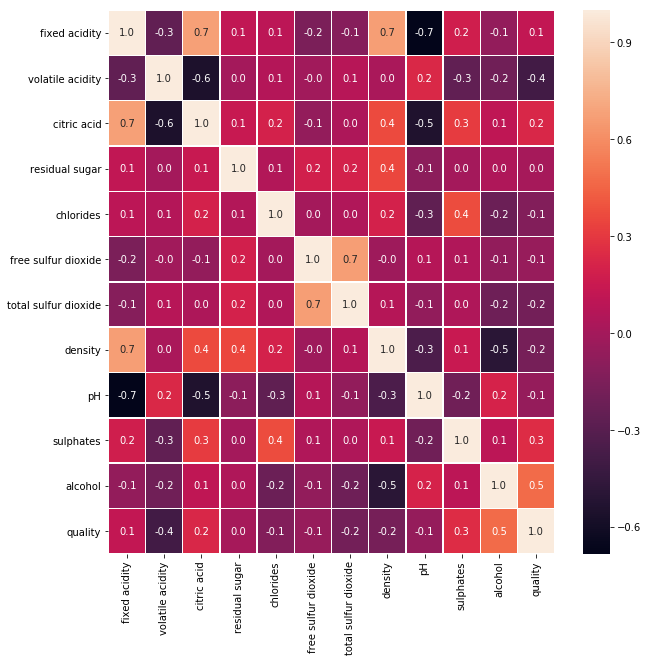

In [165]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

Comprobamos como están repartido el alcohol según el tipo de tag asignada.

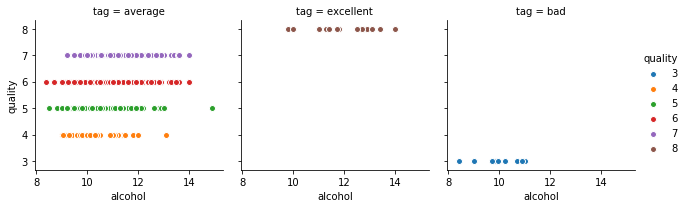

In [161]:
g = sns.FacetGrid(df, col="tag",  hue="quality")
g = (g.map(plt.scatter, "alcohol", "quality", edgecolor="w").add_legend())

Realizamos el test no paramétrico de Mann-Whitney.

In [163]:
alpha = 0.05
manwhitney_result = mannwhitneyu(average_wines['alcohol'], excellent_wines['alcohol'])
print(manwhitney_result.pvalue < alpha)

True


Modelo de Regresión Lineal.

In [172]:
correlations = df.corr()['quality'].drop('quality')
correlations

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64

In [191]:
def get_features(correlation_threshold):
    abs_corrs = correlations.abs()
    high_correlations = abs_corrs[abs_corrs > correlation_threshold].index.values.tolist()
    return high_correlations

Obtenemos aquellas características cuya correlación es superior a 0.05 como input x y la calidad como variable objetivo y.

In [193]:
features = get_features(0.05) 
x = df[features] 
y = df['quality']

In [197]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3)

In [198]:
regressor = LinearRegression()
regressor.fit(x_train,y_train)
  
print(regressor.coef_)

[ 0.01773723 -0.99256049 -0.13962865 -1.59094279  0.00559652 -0.00351973
  0.76859036 -0.43741414  0.81288805  0.30148385]


In [204]:
test_pred = regressor.predict(x_test) 
print(test_pred)

[5.10801475 5.65933623 5.90407267 6.13461179 5.00611866 5.44514691
 5.05735245 6.15497513 5.51919603 5.77259374 5.61809366 5.23616173
 5.23544213 5.31968644 6.47007277 5.043404   5.85287121 5.19427909
 6.07727089 6.34949018 6.42525555 5.51221957 5.8030796  4.93637817
 5.16618356 5.48255293 5.13758624 6.60000969 5.88754763 5.74133915
 6.09716961 6.29379754 4.91269821 5.88611904 5.11007273 5.94574773
 6.80685536 5.04305653 5.25438683 5.88611904 5.17406542 4.84008442
 6.48781656 5.40521715 5.31105571 5.84484462 5.7100681  5.24300809
 5.25021217 5.46398911 5.08740494 5.61369555 6.01375792 6.32497377
 5.47511954 5.36466869 5.09234555 4.92625623 5.21415941 5.08274744
 4.79570013 5.4377645  5.25237771 5.68830391 5.85145609 6.52420079
 5.38691412 5.71775637 5.17641417 5.99156845 5.6445189  5.60892012
 5.74967567 5.21702288 5.97975854 5.51115845 5.41121547 5.6832459
 5.63971524 5.74133915 6.24163428 5.27915822 4.66596769 6.04951743
 5.52401618 5.17823915 5.20672986 5.96322663 5.50411353 5.64866

Evaluamos la efectividad del modelo.

In [216]:
rmse = sqrt(mean_squared_error(y_test, test_pred))
rmse

0.6275381539230979

Evaluamos cómo están repartidos los valores de la predicción.

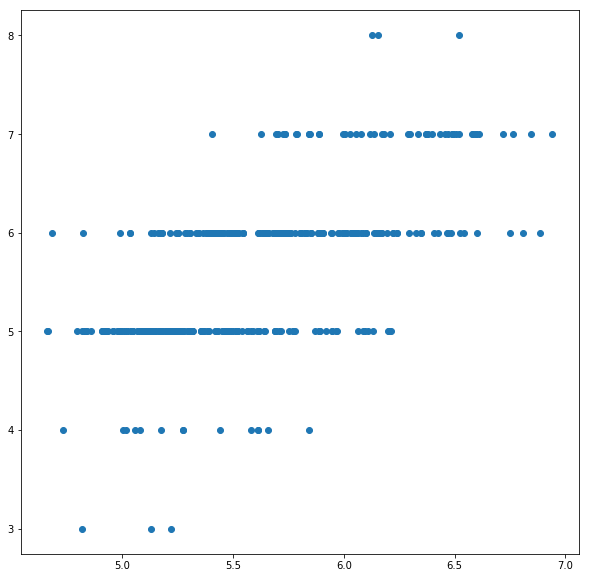

In [227]:
plt.figure(figsize=(10,10))
plt.scatter(test_pred, y_test)
plt.show()

Utilizamos también un boxplot.

{'whiskers': [<matplotlib.lines.Line2D at 0x22f26acc240>,
 'caps': [<matplotlib.lines.Line2D at 0x22f2794ffd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22f2794f550>],
 'medians': [<matplotlib.lines.Line2D at 0x22f2795a6a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22f2795a9e8>],
 'means': []}

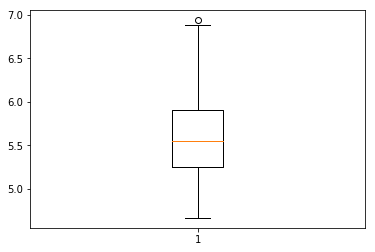

In [232]:
plt.boxplot(test_pred)